In [1]:
# Data processing/formatting
from sklearn.preprocessing import MinMaxScaler
from seqprops import SequentialPropertiesEncoder
from sklearn.model_selection import train_test_split

# for building vae model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, LSTM, Bidirectional, Conv1D, Dropout, RepeatVector, TimeDistributed, Lambda
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K

# classic required packages
import os
import random
import pandas as pd
import numpy as np
from pylab import rcParams
import importlib
import importlib.resources

# packages for graphics
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
file = 'amp.csv'
df = pd.read_csv(file)
# sequences = pd.read_csv(file, usecols=['sequence']).iloc[:, 0].values
# sequence_type = pd.read_csv(file, usecols=['label']).iloc[:, 0].values

peptides = df.loc[:, 'sequence'].values
peptides_type = df.loc[:, 'label'].values
print(peptides)
print(peptides_type)

# Determine the length of the longest sequence
max_peptide_len = 0
for peptide in peptides:
    max_peptide_len = max(len(peptide), max_peptide_len)
print("Max peptide length: ",  )

['GEP' 'QHP' 'YLRF' ...
 'MGSPEKLRPSDFSKSFLISSIRFAMSFSSFELYSACSSLIRVSSPTMAET'
 'MLLPATMSDKPDMAEIEKFDKSKLKKTETQEKNPLPSKETIEQEKQAGES'
 'GATIKKCVVDVKLSKPCTFQECQPLCLQKYNGNGLCPGDDNNICACVYNC']
[0 0 0 ... 0 0 1]
Max peptide length:  50


In [3]:
df['label'].value_counts()

0    5701
1    3708
Name: label, dtype: int64

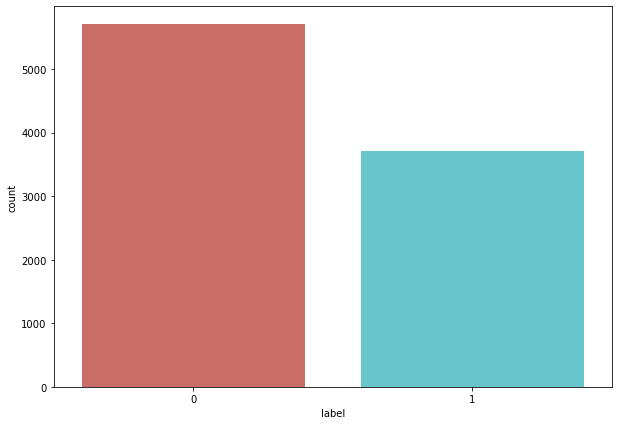

<Figure size 720x504 with 0 Axes>

In [4]:
rcParams['figure.figsize'] =  10,7
sns.countplot(x = 'label', data=df, palette='hls')
plt.show()
plt.savefig('count_plot')

In [5]:
### TRAIN TEST SPLIT ###
# print("Shape of all sequences: ", all_seq_encoded.shape)
# train_size = 0.8

# sequence_input_train = all_seq_encoded[:int(len(all_seq_encoded) * train_size)]
# sequence_input_test = all_seq_encoded[int(len(all_seq_encoded) * train_size):]
# print(sequence_input_train.shape, sequence_input_test.shape)

# sequence_target_train = sequences_type[:int(len(sequences_type) * train_size)]
# sequence_target_test = sequences_type[int(len(sequences_type) * train_size):]
# print(sequence_target_train.shape, sequence_target_test.shape)

(x_train_peptides, x_test_peptides, y_train, y_test) = train_test_split(peptides, peptides_type, test_size=0.2, random_state=42)

print(x_train_peptides.shape)
print(x_test_peptides.shape)

(7527,)
(1882,)


In [18]:
# TODO: pitat kako tocno SequentialPropertiesEncoder radi - da znam objasnit u radu (kako tocno radi encode)
# encoder = SequentialPropertiesEncoder(scaler=MinMaxScaler(feature_range=(-1, 1)))
encoder = SequentialPropertiesEncoder(scaler=MinMaxScaler(feature_range=(-1, 1)), max_seq_len=max_peptide_len-1, stop_signal=True)

x_train = encoder.encode(x_train_peptides)
x_test = encoder.encode(x_test_peptides)

# to see what data looks like
print(x_train[:2])

# Batch = 1 or more Samples
# encoder_shape = (Samples, Time Steps, Features)
whole_shape = x_train.shape
print(whole_shape)

# shape needed for encodedr model
shape = x_train.shape[1:]
print(shape)

[[[ 0.74        0.41716567 -0.10943396 ...  0.14394904 -0.93208431
    0.        ]
  [-0.74       -1.         -0.13207547 ...  0.37919321 -0.1528103
    0.        ]
  [ 0.7         0.66866267 -0.00377358 ... -0.0836518  -0.65866511
    0.        ]
  ...
  [ 0.          0.          0.         ...  0.          0.
    1.        ]
  [ 0.          0.          0.         ...  0.          0.
    1.        ]
  [ 0.          0.          0.         ...  0.          0.
    1.        ]]

 [[ 0.92        0.99201597  0.5245283  ... -0.36985138 -0.31381733
    0.        ]
  [ 0.92        0.99201597  0.5245283  ... -0.36985138 -0.31381733
    0.        ]
  [-0.64       -0.15768463 -0.64528302 ...  0.08195329 -0.2617096
    0.        ]
  ...
  [-0.74       -1.         -0.13207547 ...  0.37919321 -0.1528103
    0.        ]
  [ 0.92        0.99201597  0.5245283  ... -0.36985138 -0.31381733
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    1.        ]]]
(7527, 50, 95)
(50, 95)

In [19]:
# encoder model definition
def create_seq_encoder_model(input_shape, latent_dim=2, lstm_cells=64):
    inp = Input(shape=input_shape, name="input_1_enc")
    
    x = LSTM(lstm_cells, unroll=True, name="lstm_enc")(inp)
    z = Dense(16, activation='relu', name="output_dense_enc")(x)
    z_mean = Dense(latent_dim)(z)
    z_log_sigma = Dense(latent_dim)(z)
    
    encoder_model = Model(inputs=inp, outputs=[z_mean, z_log_sigma], name="encoder")
    return encoder_model

In [20]:
# decoder model definition
def create_seq_decoder_model(input_shape, latent_dim=2, lstm_cells=64):
    model_input = Input(shape=(latent_dim,), name="input_1_dec")
#   repeating for the number of time steps
    x = RepeatVector(input_shape[0])(model_input)
#   return_sequences - whether to return the last output in the output sequence, or the full sequence
    x = LSTM(lstm_cells, unroll=True, name="lstm_dec", return_sequences=True)(x)
#   applies layer for every temporal slice of an input - feature
    out = TimeDistributed(Dense(input_shape[1]))(x)
    
    decoder_model = Model(inputs=model_input, outputs=out, name="decoder")
    return decoder_model

In [21]:
# setting latent space to 2 dimension
latent_dim = 2

# setting fixed randomizer
def set_seed(seed):
    
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)

# sampling from latent space
def sampling(args):
    
    z_mean, z_log_sigma = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_sigma) * epsilon

# loss function defined from reconstruction param and regularisation term (expressed as the Kulback-Leibler (KL) divergence)
def vae_loss(inp, reconstruction, z_log_sigma, z_mean):
    
    kl_loss = tf.reduce_mean(-0.5 * tf.reduce_sum(1 + z_log_sigma - tf.square(z_mean) - tf.exp(z_log_sigma), axis=1))
    
#   binary_crossentropy se koristi u inace (dobivam negativni loss), zato je tu postalvjen mean_squared_error
#   Use this cross-entropy loss for binary (0 or 1) classification applications
    reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.mean_squared_error(inp, reconstruction), axis=1
                )
            )
    
    return reconstruction_loss + kl_loss

def get_model():
    
    set_seed(31)
    
    ### encoder ###
    encoder = create_seq_encoder_model(input_shape=shape)  # shape (Time Steps, Features)
    encoder.summary()

    ### decoder ###
    decoder = create_seq_decoder_model(input_shape=shape, latent_dim=2)
    decoder.summary()

    ### encoder + decoder ###
    inp = Input(shape=shape, name="vae_encoder_input")
    z_mean, z_log_sigma = encoder(inp)
    z = Lambda(sampling)([z_mean, z_log_sigma])
     
    reconstruction = decoder(z)
    
    vae = Model(inp, reconstruction, name="vae_model")
    vae.add_loss(vae_loss(inp, reconstruction, z_log_sigma, z_mean))
    vae.compile(optimizer=keras.optimizers.Adam())
    
    return vae, encoder, decoder

In [22]:
es = EarlyStopping(patience=10, verbose=1, min_delta=0.001, monitor='val_loss', mode='auto', restore_best_weights=True)
vae, enc, dec = get_model()
# https://blog.keras.io/building-autoencoders-in-keras.html
# reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)

vae.fit(x_train, batch_size=128, epochs=100, validation_data=(x_test, None), callbacks=[es])

vae.fit([sequence_input_train[:,:,i] for cat,i in map_col.items()] + [sequence_target_drop_train, sequence_target_train], 
         batch_size=128, epochs=100, validation_split=0.2, shuffle=False, callbacks=[es])

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1_enc (InputLayer)       [(None, 50, 95)]     0           []                               
                                                                                                  
 lstm_enc (LSTM)                (None, 64)           40960       ['input_1_enc[0][0]']            
                                                                                                  
 output_dense_enc (Dense)       (None, 16)           1040        ['lstm_enc[0][0]']               
                                                                                                  
 dense_6 (Dense)                (None, 2)            34          ['output_dense_enc[0][0]']       
                                                                                            

Epoch 56/100
59/59 [==============================] - 6s 98ms/step - loss: 9.8293 - val_loss: 9.8417
Epoch 57/100
59/59 [==============================] - 6s 95ms/step - loss: 9.8303 - val_loss: 9.8462
Epoch 58/100
59/59 [==============================] - 6s 96ms/step - loss: 9.8300 - val_loss: 9.8457
Epoch 59/100
59/59 [==============================] - 6s 94ms/step - loss: 9.8276 - val_loss: 9.8409
Epoch 60/100
59/59 [==============================] - 5s 92ms/step - loss: 9.8291 - val_loss: 9.8428
Epoch 61/100
59/59 [==============================] - 5s 92ms/step - loss: 9.8284 - val_loss: 9.8434
Epoch 62/100
59/59 [==============================] - 6s 94ms/step - loss: 9.8266 - val_loss: 9.8413
Epoch 63/100
59/59 [==============================] - 6s 109ms/step - loss: 9.8241 - val_loss: 9.8397
Epoch 64/100
59/59 [==============================] - 6s 98ms/step - loss: 9.8272 - val_loss: 9.8380
Epoch 65/100
59/59 [==============================] - 6s 105ms/step - loss: 9.8266 - val_l

In [23]:
### LATENT REPRESENTATION OF TEST DATA ###

# encode data into the latent space
# provjerit sta je na prvom mjestu sta na drugom i zasto on ima 3 a ja 2 
encoded_x_train, _ = enc.predict(x_train)
print(encoded_x_train.shape)
print(encoded_x_train)

236/236 [==============================] - 3s 9ms/step
(7527, 2)
[[ 8.9283363e-05 -1.2981001e-03]
 [ 8.9283363e-05 -1.2981001e-03]
 [ 8.9283363e-05 -1.2981001e-03]
 ...
 [ 8.9283363e-05 -1.2981001e-03]
 [ 8.9283363e-05 -1.2981001e-03]
 [ 8.9283363e-05 -1.2981001e-03]]


59/59 [==============================] - 1s 8ms/step


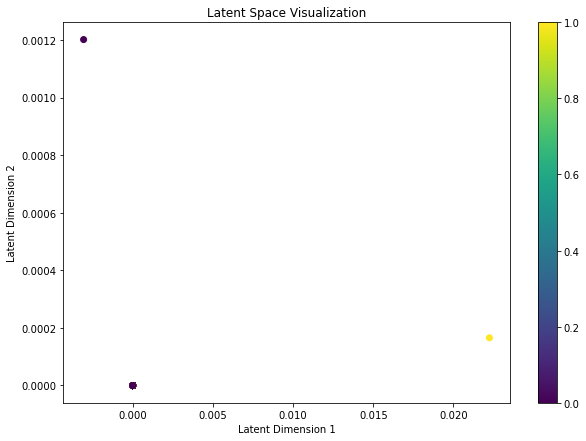

In [24]:
from sklearn.decomposition import PCA

# Encode the test data using the trained encoder
z_mean, _ = enc.predict(x_test)

# Apply PCA to reduce dimensions for visualization
pca = PCA(n_components=2)
latent_pca = pca.fit_transform(z_mean)

# Create scatter plot of the latent space
plt.scatter(latent_pca[:, 0], latent_pca[:, 1], c=y_test, cmap='viridis')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('Latent Space Visualization')
plt.colorbar()
plt.show()

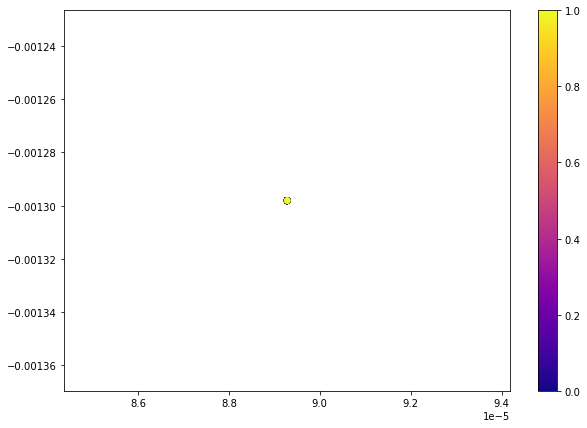

In [25]:
plt.scatter(encoded_x_train[:,0], encoded_x_train[:,1], c=y_train ,cmap='plasma')
plt.colorbar()
plt.show()

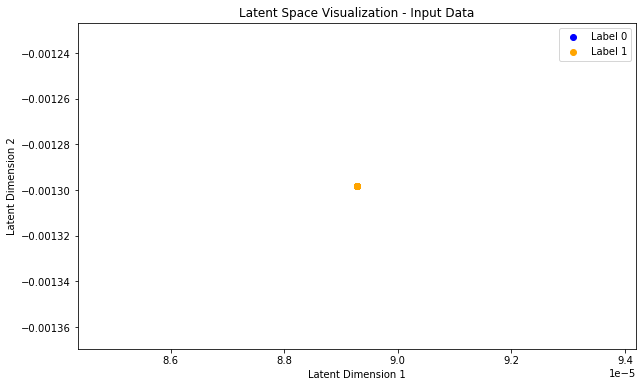

In [26]:
label_colors = {0: 'blue', 1: 'orange'}

# input data
plt.figure(figsize=(10, 6))
for label in range(2):
    indices_train = np.where(y_train == label)[0]
    plt.scatter(encoded_x_train[indices_train, 0], encoded_x_train[indices_train, 1], c=label_colors[label],
                label='Label {}'.format(label))
plt.title('Latent Space Visualization - Input Data')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.legend()
plt.show()

In [28]:
enc_pred, _ = enc.predict(x_train)
decoded_data = dec.predict(enc_pred)


def closest_letter(unknown_seq):
    min_dif = 999999999999999
    current_closest_letter = None
    
    for letter, seq in encoder.mappings.items():
        if np.correlate(unknown_seq, seq)[0] < min_dif:
            min_dif = np.correlate(unknown_seq, seq)[0]
            current_closest_letter = letter
    
    return current_closest_letter

# print(decoded_data)

decoded_data_original = []
seq_to_letter = ''
for sequence_array in decoded_data:
    for seq in sequence_array:
        seq_to_letter += closest_letter(seq)
    decoded_data_original.append(seq_to_letter)
#     print(seq_to_letter)
    seq_to_letter = ''

print(decoded_data_original)   
# for letter, seq in encoder.mappings.items():
#     print(letter)
#     print(seq)

236/236 [==============================] - 2s 8ms/step
['RWWWRRRWRRWWRRWRRRWRRRRRRRWWWWWWWWWWWWWWWWWWWWWFFF', 'RWWWRRRWRRWWRRWRRRWRRRRRRRWWWWWWWWWWWWWWWWWWWWWFFF', 'RWWWRRRWRRWWRRWRRRWRRRRRRRWWWWWWWWWWWWWWWWWWWWWFFF', 'RWWWRRRWRRWWRRWRRRWRRRRRRRWWWWWWWWWWWWWWWWWWWWWFFF', 'RWWWRRRWRRWWRRWRRRWRRRRRRRWWWWWWWWWWWWWWWWWWWWWFFF', 'RWWWRRRWRRWWRRWRRRWRRRRRRRWWWWWWWWWWWWWWWWWWWWWFFF', 'RWWWRRRWRRWWRRWRRRWRRRRRRRWWWWWWWWWWWWWWWWWWWWWFFF', 'RWWWRRRWRRWWRRWRRRWRRRRRRRWWWWWWWWWWWWWWWWWWWWWFFF', 'RWWWRRRWRRWWRRWRRRWRRRRRRRWWWWWWWWWWWWWWWWWWWWWFFF', 'RWWWRRRWRRWWRRWRRRWRRRRRRRWWWWWWWWWWWWWWWWWWWWWFFF', 'RWWWRRRWRRWWRRWRRRWRRRRRRRWWWWWWWWWWWWWWWWWWWWWFFF', 'RWWWRRRWRRWWRRWRRRWRRRRRRRWWWWWWWWWWWWWWWWWWWWWFFF', 'RWWWRRRWRRWWRRWRRRWRRRRRRRWWWWWWWWWWWWWWWWWWWWWFFF', 'RWWWRRRWRRWWRRWRRRWRRRRRRRWWWWWWWWWWWWWWWWWWWWWFFF', 'RWWWRRRWRRWWRRWRRRWRRRRRRRWWWWWWWWWWWWWWWWWWWWWFFF', 'RWWWRRRWRRWWRRWRRRWRRRRRRRWWWWWWWWWWWWWWWWWWWWWFFF', 'RWWWRRRWRRWWRRWRRRWRRRRRRRWWWWWWWWWWWWWWWWWWWWWFFF', 'RWWWRRRWRRWWRRWRRRWRRRRRR